<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Preparation</a></span></li><li><span><a href="#Categorical-encoding-scheme" data-toc-modified-id="Categorical-encoding-scheme-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Categorical encoding scheme</a></span><ul class="toc-item"><li><span><a href="#Channels-column" data-toc-modified-id="Channels-column-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Channels column</a></span></li><li><span><a href="#Offer-type-column" data-toc-modified-id="Offer-type-column-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Offer type column</a></span></li><li><span><a href="#Gender-column" data-toc-modified-id="Gender-column-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Gender column</a></span></li><li><span><a href="#Target:-Event-encoding" data-toc-modified-id="Target:-Event-encoding-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Target: Event encoding</a></span></li><li><span><a href="#Offer-id-and-customer-id" data-toc-modified-id="Offer-id-and-customer-id-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Offer id and customer id</a></span></li></ul></li><li><span><a href="#Imputation" data-toc-modified-id="Imputation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Imputation</a></span><ul class="toc-item"><li><span><a href="#Filling-NaN-values" data-toc-modified-id="Filling-NaN-values-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Filling NaN values</a></span></li></ul></li><li><span><a href="#Multilabel-Classification" data-toc-modified-id="Multilabel-Classification-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Multilabel Classification</a></span><ul class="toc-item"><li><span><a href="#Test-set-for-model-evaluation" data-toc-modified-id="Test-set-for-model-evaluation-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Test set for model evaluation</a></span></li><li><span><a href="#Random-Search-XGB-model" data-toc-modified-id="Random-Search-XGB-model-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Random Search XGB model</a></span></li><li><span><a href="#Model-Evaluation" data-toc-modified-id="Model-Evaluation-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Model Evaluation</a></span></li><li><span><a href="#BASELINE:-Random-class-distribution-prediction" data-toc-modified-id="BASELINE:-Random-class-distribution-prediction-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>BASELINE: Random class distribution prediction</a></span></li></ul></li></ul></div>

## Data Preparation

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import joblib

from ml_test_tools import test_model, rank_top_performers, plot_features_importance

sns.set(style='darkgrid')
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [37]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [38]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [39]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [40]:
df_1 = pd.merge(left=profile, right=transcript, left_on='id', right_on='person')

In [41]:
df_1 = df_1.drop('person', axis=1)

In [42]:
def parse_value_keys(row, value_type):
    if value_type in row.keys():
        label = row[value_type]
        return label
    else: pass

In [43]:
df_1['reward_amount'] = df_1.value.apply(lambda x: parse_value_keys(x, 'reward'))
df_1['transaction_amount'] = df_1.value.apply(lambda x: parse_value_keys(x, 'amount'))
df_1['offer_id'] = df_1.value.apply(lambda x: parse_value_keys(x, 'offer id'))

In [44]:
df_2 = pd.merge(left=df_1, right=portfolio, left_on='offer_id', right_on='id', how='outer',suffixes=('_customer','_offer'))

In [45]:
df_complete = df_2.drop(['value','id_offer'], axis=1)

In [46]:
df_complete.head()

,age,became_member_on,gender,id_customer,income,event,time,reward_amount,transaction_amount,offer_id,channels,difficulty,duration,offer_type,reward
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,offer received,168,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10.0,7.0,discount,2.0
1,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,offer viewed,216,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10.0,7.0,discount,2.0
2,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10.0,7.0,discount,2.0
3,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,offer viewed,18,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10.0,7.0,discount,2.0
4,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,offer received,408,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10.0,7.0,discount,2.0


In [47]:
df_complete['channels'] = df_complete['channels'].str.len()

In [48]:
df_complete.isnull().sum()

age                        0
became_member_on           0
gender                 33772
id_customer                0
income                 33772
event                      0
time                       0
reward_amount         272955
transaction_amount    167581
offer_id              172532
channels              172532
difficulty            172532
duration              172532
offer_type            172532
reward                172532
dtype: int64

## Categorical encoding scheme

### Channels column

The channels column wil be converted to length. All channels have `[web, email]` which will be two. `[web, email, mobile]` is three,  and `[web, email, mobile, social]` is now 4. 

### Offer type column

The offer types are also numeric now `bogo` = 1, `discount` = 2, and `informational` = 3

### Gender column

`Male` = 1, `Female` = 3, `Other`=3, and None = 0
Other and none may be in some way linked via identity, but I'll keep them separate in the event that it is significant. 

### Target: Event encoding

Offer recieved and offer viewed, while important for demographics, is probably not all that important in so much as they both may not convert to a sale or offer completion. As such, I'll group them together and try to predict completion, transaction, or none.

TARGET Encoding:
`offer viewed` and `offer received` = 0, `transaction` = 1, `offer completed` = 2

### Offer id and customer id

These unique identitfiers will be replaced by integer hash ids so they can be tracked. 

## Imputation

Income value will be filled with the median value only about 11% of the income data is missing, so this is both safe and unlikely to bias the model in a meaningful way. To be on the safe side, I'll fill the values inside the cross validation folds so as to spread out the filled values relative to the CV fold. 

In [49]:
def parse_offers(row):
    if row == 'bogo':
        label = 1
    elif row == 'discount':
        label = 2
    else: label = 3
    return label

In [50]:
df_complete['offer_type'] = df_complete.offer_type.apply(lambda x: parse_offers(x))

In [51]:
events = {'offer received':0,'offer viewed':0,'offer completed':2,'transaction':1}
genders = {'M':1,'F':2, 'O':3, None:0}

df_complete.event = [events[item] for item in df_complete.event]
df_complete.gender = [genders[item] for item in df_complete.gender]

In [52]:
#df_complete.income.fillna(value=df_complete.income.median(), inplace=True)

In [53]:
df_complete.id_customer = [hash(uid) for uid in df_complete.id_customer]
df_complete.offer_id = [hash(oid) for oid in df_complete.offer_id]

### Filling NaN values

In [54]:
df_complete.isnull().sum()

age                        0
became_member_on           0
gender                     0
id_customer                0
income                 33772
event                      0
time                       0
reward_amount         272955
transaction_amount    167581
offer_id                   0
channels              172532
difficulty            172532
duration              172532
offer_type                 0
reward                172532
dtype: int64

Channels, difficulty, duration, and reward all have the same number of missing. They are then likely the observations in which an offer was not attempted. Reward amount can be zeroed for Null values, as those were likely 0 reward given. I assume that Null values for transaction amounts were either zero dollars or some other interaction that was outside the ability to track. Thus this remaining values will be filled with zeros. 

In [63]:
values = {'reward_amount':0,
          'transaction_amount':0,
          'channels':0,
          'difficulty':0,
          'duration':0,
          'reward':0}
df_complete.fillna(value=values, inplace=True)

In [67]:
df_complete.isnull().sum()

age                       0
became_member_on          0
gender                    0
id_customer               0
income                33772
event                     0
time                      0
reward_amount             0
transaction_amount        0
offer_id                  0
channels                  0
difficulty                0
duration                  0
offer_type                0
reward                    0
dtype: int64

In [68]:
df_complete.head()

,age,became_member_on,gender,id_customer,income,event,time,reward_amount,transaction_amount,offer_id,channels,difficulty,duration,offer_type,reward
0,118,20170212,0,-6118677641434346028,NaN,0,168,0.0,0.0,6812568168499232363,3.0,10.0,7.0,2,2.0
1,118,20170212,0,-6118677641434346028,NaN,0,216,0.0,0.0,6812568168499232363,3.0,10.0,7.0,2,2.0
2,68,20180426,1,-8854229372366362354,70000.0,0,0,0.0,0.0,6812568168499232363,3.0,10.0,7.0,2,2.0
3,68,20180426,1,-8854229372366362354,70000.0,0,18,0.0,0.0,6812568168499232363,3.0,10.0,7.0,2,2.0
4,118,20170925,0,-6795999993149573153,NaN,0,408,0.0,0.0,6812568168499232363,3.0,10.0,7.0,2,2.0


In [69]:
save_dataframe = True
load_dataframe = False
if save_dataframe == True:
    print('Saving dataframe')
    joblib.dump(df_complete, 'data/dataframe')
if load_dataframe == True:
    df_complete = joblib.load('data/dataframe')

Saving dataframe


Let's see if we can do a prediction for users who are likely to acheive any of the three labeled **events**. We can tag this outcome with probabilities to understand who is most likely to achieve each event type. 

We can then possible work backwards to understand the profile of a customer who is likely to acheive a given offer - or which offers typically give us specific **event** outcomes. 

## Multilabel Classification

In [ ]:
# !conda install -y -c conda-forge xgboost
# This make need to be loaded for AWS

### Test set for model evaluation

In [70]:
X = df_complete.drop('event', axis=1)
y = df_complete.event

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=9450)

In [72]:
training_set = pd.concat([X_train, y_train],axis=1)

### Random Search XGB model

In [73]:
models = {}

In [74]:
import random
N_TRIALS = 3
for i in range(N_TRIALS):
    learning_rate_factor = random.randint(1,25)
    xgb_rs = xgb.XGBClassifier(
        learning_rate=0.25 / learning_rate_factor,
        n_estimators=random.randint(20, 400),
        max_depth=random.randint(2, 10),
        min_child_weight=random.randint(1, 10),
        gamma=random.randint(0, 50)/5,
        subsample=1-(random.randint(1, 60)/100),
        colsample_bytree=1-(random.randint(1, 60)/100),
        random_state=9450, 
        objective='multi:softmax'
    )
    model = test_model(training_set, xgb_rs, cv_folds=5, model_id=i)
    models.update({i:model})

In [75]:
rank_top_performers(models, metric='accuracy')

[{'model_id': 0,
  'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=0.69, gamma=4.0, learning_rate=0.0625,
                max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
                n_estimators=217, n_jobs=1, nthread=None,
                objective='multi:softprob', random_state=9450, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
                subsample=0.89),
  'f1_score': {'mean': 1.0, 'sd': 0.0},
  'recall': {'mean': 1.0, 'sd': 0.0},
  'precision': {'mean': 1.0, 'sd': 0.0},
  'specificity': {'mean': 1.0, 'sd': 0.0},
  'balanced_accuracy': {'mean': 1.0, 'sd': 0.0},
  'accuracy': {'mean': 1.0, 'sd': 0.0}},
 {'model_id': 1,
  'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=0.61, gamma=3.8, learning_rate=0.0125,
                max_delta_step=0, max_depth=7, min_child_weight=9, missing=None,
       

In [76]:
top_model = models[0]['model']
top_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.69, gamma=4.0, learning_rate=0.0625,
              max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
              n_estimators=217, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=9450, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=0.89)

### Model Evaluation

In [77]:
save_model = True

load_model = False

if save_model == True:
    joblib.dump(top_model, 'data/xgb_model_1')
else: print(f'Nothing saved')
if load_model == True:
    joblib.load('data/xgb_model_1')
else: print(f'No model loaded!')

No model loaded!


In [78]:
val_preds = top_model.predict(X_test.values)

In [79]:
con_mat = confusion_matrix(y_true=y_test, y_pred=val_preds)
cls_rpt = classification_report(y_test, val_preds)
acc = accuracy_score(y_test, val_preds)

In [80]:
print(con_mat, cls_rpt, f'accuracy score: {acc:.2%}', sep='\n\n')

[[26615     0     0]
 [    0 27998     0]
 [    0     0  6694]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26615
           1       1.00      1.00      1.00     27998
           2       1.00      1.00      1.00      6694

    accuracy                           1.00     61307
   macro avg       1.00      1.00      1.00     61307
weighted avg       1.00      1.00      1.00     61307


accuracy score: 100.00%


Events are numeric as such: 
    
`offer viewed` and `offer received` = 0, `offer completed` = 2, `transaction` = 1

This is a great result for predicting something like a transaction or offer completion. If the goal is to find who will buy without offer and who will buy with an offer, then this is pretty good. 

I thought there would be some drop off in the accuracy as a result of the validation set. 

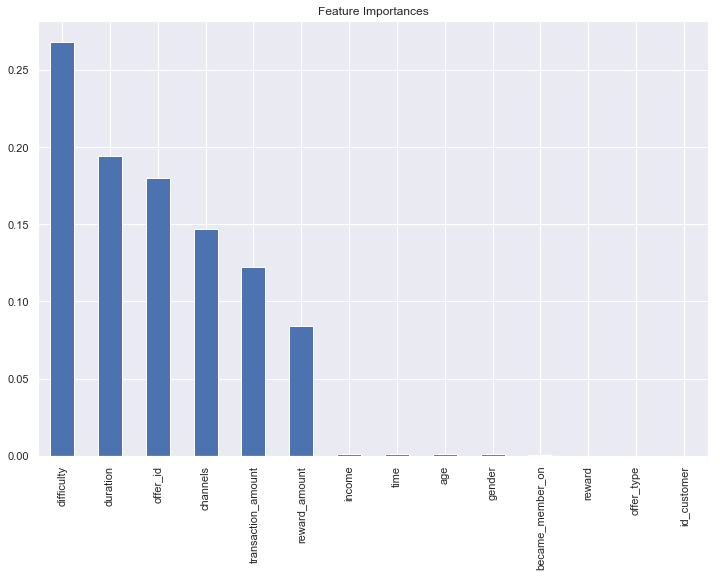

In [81]:
plot_features_importance(df_complete, top_model)

Only five features seem to dictate the likely hood a customer will transact, complete offer, or neither. One of the strongest predictors is saturation of advertising, which must make the marketing world swoon. The offer difficulty and offer id also carries a heavy predictive power, future work could be to determine the significance of each offer for completion. Reward amount was a top predictor as well, so that is also an avenue for further work. Which amount if optimal for completion.

Interestingly enough; age, gender, income, and offer type carry no (or little) predictive power.

Below are the two other random search models. Their fearure importance plot show a similar story to the one above. Age, gender, income, general demographic data doesn't not seem to be the deciding factor on who completes and offer or transacts without an offer. 

In [87]:
second_model = models[1]['model']

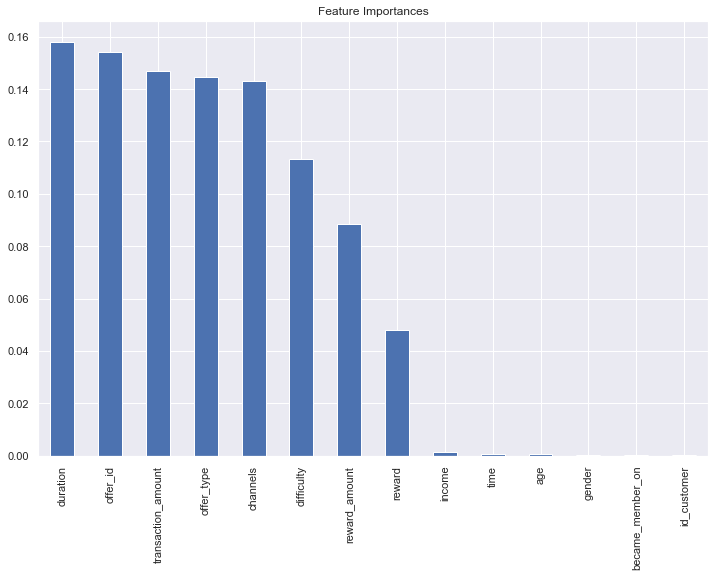

In [88]:
plot_features_importance(df_complete, second_model)

In [89]:
third_model = models[2]['model']

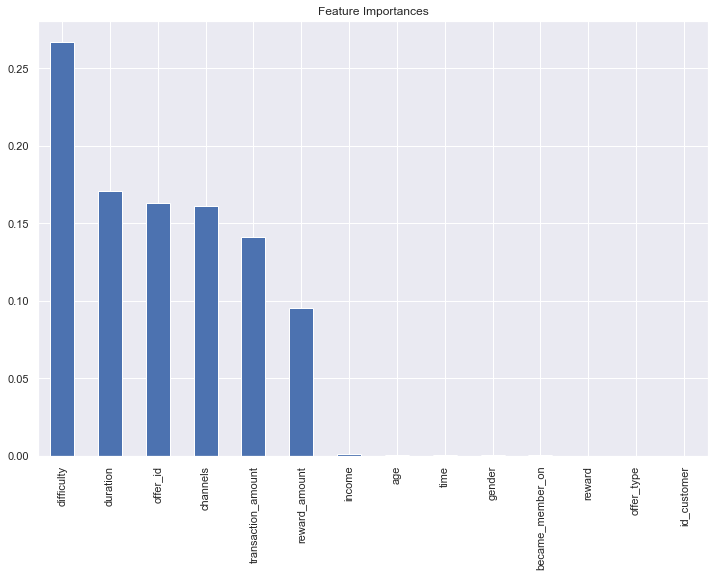

In [90]:
plot_features_importance(df_complete, third_model)

### BASELINE: Random class distribution prediction

In [82]:
random_classes = np.random.randint(0,3, size=len(y_test))

In [83]:
con_mat_ran = confusion_matrix(y_true=y_test, y_pred=random_classes)
cls_rpt_ran = classification_report(y_test, random_classes)
acc_ran = accuracy_score(y_test, random_classes)

In [84]:
print(con_mat_ran, cls_rpt_ran, f'accuracy score for random class distribution: {acc_ran:.2%}', sep='\n\n')

[[8938 8891 8786]
 [9239 9373 9386]
 [2290 2159 2245]]

              precision    recall  f1-score   support

           0       0.44      0.34      0.38     26615
           1       0.46      0.33      0.39     27998
           2       0.11      0.34      0.17      6694

    accuracy                           0.34     61307
   macro avg       0.34      0.34      0.31     61307
weighted avg       0.41      0.34      0.36     61307


accuracy score for random class distribution: 33.53%


So a random selection of classes, would be what we expect in terms of accuracy. The predictive power of completing offers is particularly low for a random distribution of offer completion classes. 